In [2]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import glob

In [3]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

# ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

0.34.1


In [4]:
#Note 1/18/23: Flux tower footprint (fluxproper) OR expanded flux area (fluxdiss) OR all gce (gce_clip)

gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_sapelodissolve.shp'

gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'

gce_fluxproper = 'F:/Wetlands shapefiles/GCE flux tower/2014-climatology.shp'

gce_expandedflux = 'F:/Wetlands shapefiles/GCE flux tower/expanded_flux.shp' ## Added 9/18/23 - fix shapefile problems!

flux_ga = geemap.shp_to_ee(gce_expandedflux)

## DEM
elevation = ee.Image('USGS/3DEP/10m').clip(flux_ga) ##This is 1/3 arc second, or 10 m.

In [5]:
Map.addLayer(geemap.shp_to_ee(gce_clip))
Map

Map(center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

In [6]:
#Pixel counts of each region:
image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')
x = image.reduceRegion(geometry=flux_ga, reducer=ee.Reducer.count(), scale=30)
x.getInfo()

{'QA_PIXEL': 1946,
 'QA_RADSAT': 1946,
 'SR_ATMOS_OPACITY': 1946,
 'SR_B1': 1946,
 'SR_B2': 1946,
 'SR_B3': 1946,
 'SR_B4': 1946,
 'SR_B5': 1946,
 'SR_B7': 1946,
 'SR_CLOUD_QA': 1453,
 'ST_ATRAN': 1946,
 'ST_B6': 1946,
 'ST_CDIST': 1946,
 'ST_DRAD': 1946,
 'ST_EMIS': 1946,
 'ST_EMSD': 1946,
 'ST_QA': 1946,
 'ST_TRAD': 1946,
 'ST_URAD': 1946}

In [7]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

In [8]:
# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)


#Function to add elevation

def add_elevation(image):
    elevation_band = elevation.rename('elevation')
    return image.addBands(elevation_band)

In [9]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [10]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation)


bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])


In [11]:
## NO VARIABLE THRESHOLD
# ultra_col = l8_col.merge(l5_col).merge(l7_col).merge(l9_col)

# # ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)
# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bb)) \
#     .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

# #Percentage of pixels in study area flagged, ALL =----= MIGHT BE A BETTER WAY TO DO THIS

# study_area = flux_ga.geometry()

# # Define the threshold value
# threshold = 0.2

# # Function to calculate binary image for 'flats' values greater than the threshold
# def calculate_binary_image(image):
#     flats_band = image.select('flats')
#     binary_image = flats_band.gt(threshold)
#     return binary_image

# # Map the function over the collection to get binary images
# binary_images = ultra.map(calculate_binary_image)

# # Function to count valid pixels
# def count_valid_pixels(image):
#     valid_pixel_count = image.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=study_area,
#         scale=30  # Assuming 30-meter resolution
#     ).get('flats')
#     return image.set('valid_pixel_count', valid_pixel_count)

# # Map the function over the binary images to count valid pixels
# binary_images_with_count = binary_images.map(count_valid_pixels)

# # Filter the collection to exclude scenes with fewer than 100 valid pixels
# filtered_images = binary_images_with_count.filter(ee.Filter.gte('valid_pixel_count', 0))

# # Reduce the filtered collection to a single image with pixel count
# total_count_image = filtered_images.sum()

# # Calculate the percentage of times each pixel exceeded the threshold
# total_images = filtered_images.size()
# percentage_image = total_count_image.divide(total_images).multiply(100)

# # Map = geemap.Map()
# # Map.centerObject(flux_ga, 8)
# # Map.addLayer(percentage_image, {
# #     'min': 0,
# #     'max': 100,
# #     'palette': ['brown', 'aqua']
# # }, 'Percentage of Times > 0.2')
# # Map

In [12]:
# ELEVATION-DEPENDENT THRESHOLDING ADDED 11/6/23

ultra_col = l8_col.merge(l5_col).merge(l7_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).filterBounds(flux_ga)
ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

#Percentage of pixels in study area flagged

study_area = flux_ga.geometry()

# Define the elevation band within the Landsat images
# elevation_band = ee.Image('USGS/3DEP/10m').select('elevation')

# Function to calculate the binary image for 'flats' values based on elevation threshold
def calculate_binary_image(image):
    flats_band = image.select('flats')
    
    elevation_band = image.select('elevation')
    
    # Define the different thresholds based on elevation
    threshold_below_elevation = 0.2
    threshold_above_elevation = 0.8

    # Condition for masking based on elevation using expression()
    threshold_mask = flats_band.expression(
        "(elev >= 0.5) ? flats > threshold_above : flats > threshold_below",
        {
            'elev': image.select('elevation'), 
            'flats': flats_band,
            'threshold_above': threshold_above_elevation,
            'threshold_below': threshold_below_elevation
        }
    )

    return threshold_mask

# Map the function over the collection to get threshold masks based on elevation
threshold_masks = ultra.map(calculate_binary_image)

# Function to count valid pixels based on elevation-specific thresholds
def count_valid_pixels(image):
    valid_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=study_area,
        scale=30  # Assuming 30-meter resolution
    ).get('flats')
    return image.set('valid_pixel_count', valid_pixel_count)

# Map the function over the threshold masks to count valid pixels
threshold_masks_with_count = threshold_masks.map(count_valid_pixels)

# Filter the collection to exclude scenes with fewer than 100 valid pixels
filtered_images = threshold_masks_with_count.filter(ee.Filter.gte('valid_pixel_count', 0))

# Reduce the filtered collection to a single image with pixel count
total_count_image = filtered_images.sum()

# Calculate the percentage of times each pixel exceeded the threshold
total_images = filtered_images.size()
percentage_image = total_count_image.divide(total_images).multiply(100)


In [13]:
# x=ultra_col.toList(ultra_col.size())
# ultra_col.size()

In [14]:
# Map = geemap.Map()
# Map.centerObject(flux_ga, 12)
# Map.addLayer(ultra.first().select('elevation'), {
#     'min': 0,
#     'max': 3,
#     'palette': ['brown', 'aqua']
# }, 'Percentage of Times > 0.2')

# Map

In [15]:
#Directory
out_dir = os.path.join("F:/Flats imagery")
##Draw geometry for exported images! It will look better

bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

image = percentage_image
filename = os.path.join(out_dir, '84_elev_23.tif')

image = image.clip(bb).unmask()

# geemap.ee_export_image(
#     image.select('flats'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )


In [16]:
# ##ALSO MAP: PERCENT TIME FLAGGED AS CLOUDY, PREFILTERED
# ##STRIPING DUE TO L7s
# #Loading gee datasets
# l8_unf = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
#     .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
#     .filterBounds(flux_ga)

# l7_unf = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
#     .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
#     .filterBounds(flux_ga)

# l5_unf = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
#     .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
#     .filterBounds(flux_ga)

# l9_unf = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
#     .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
#     .filterBounds(flux_ga)

# ultra_unfiltered = l8_unf.merge(l5_unf).merge(l9_unf) #Took out l7 due to striping!

# def calculate_cloud_mask(image):
#     qa_pixel = image.select('QA_PIXEL')  # QA_PIXEL band for Landsat 8 Collection 2
#     return qa_pixel.bitwiseAnd(int('11111', 2)).eq(0)

# # Map the function over the image collection to get binary cloud masks
# cloud_masks = ultra_unfiltered.map(calculate_cloud_mask)

# # Reduce the collection to compute the sum of binary cloud masks for each pixel
# sum_cloud_masks = cloud_masks.reduce(ee.Reducer.sum())

# # Calculate the percentage of times each pixel is cloudy
# total_images = ultra_unfiltered.size()
# percentage_cloudy = sum_cloud_masks.divide(total_images).multiply(100)

# Map = geemap.Map()
# Map.centerObject(flux_ga, 8)
# Map.addLayer(percentage_cloudy, {
#     'min': 0,
#     'max': 100,
#     'palette': ['red', 'orange', 'yellow', 'blue', 'green']
# }, 'Percentage of times cloudy')

# # Map

EPSG:4326


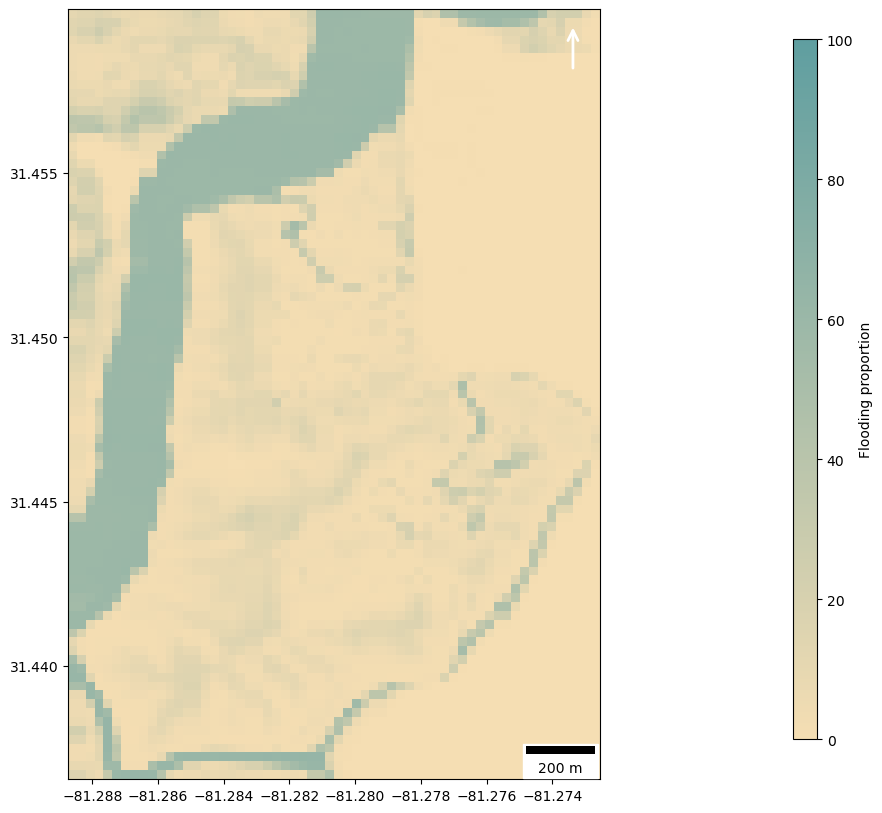

In [17]:
#Plotting
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar
import rasterio
import geopandas as gpd

# geotiff_path = "F:/Flats imagery/1984percentflats2023.flats.tif"
# geotiff_path = "F:/Flats imagery/1984percent2023.flats.tif"
geotiff_path = "F:/Flats imagery/elev_all.flats.tif"


#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)    
        
        # Use a colormap with better visibility
        cmap = colors.LinearSegmentedColormap.from_list('custom',  [(0, '#F5DEB3'), (1, '#5F9EA0')])
        
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,10))
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data, extent=extent, cmap=cmap, vmin=0, vmax=100)

        # Remove coordinate labels to make the plots larger
#         ax.set_xticks([])
#         ax.set_yticks([])

        # Add a scale bar
        # Calculate the scale factor based on the pixel size (assuming meters)
        pixel_size_x = 30  # 30 meters in the x-direction
        scale_factor = pixel_size_x

        # Add a scale bar using the calculated scale factor
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))
        
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax, label = 'Flooding proportion', cmap = \
                          colors.LinearSegmentedColormap.from_list('custom_gray',  [(0, '#F5DEB3'), (1, '#5F9EA0')]))
        
        
print(src.crs)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('all_variable.png',bbox_inches='tight', dpi = 300)


In [18]:
# #Plotting clouds

# geotiff_path = "F:/Flats imagery/1984clouds2023.QA_PIXEL_sum.tif"

# #Calculating dx for scale_bar
# from geopy.distance import great_circle
# point1 = (31.425,-81.29) 
# point2 = (31.425,-80.29)  
# dx = great_circle(point1, point2).meters

# with rasterio.open(geotiff_path) as src:
#     with rasterio.open(geotiff_path) as src:
#         data = src.read(1)  # Assuming it's a single-band image
#         extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    
#         # Use a colormap with better visibility
#         cmap = colors.LinearSegmentedColormap.from_list('custom', [(0, 'tan'), (1, 'aqua')])
        
#         fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,10))
        
#         # Plot the GeoTIFF data using imshow
#         im = ax.imshow(data, extent=extent, cmap=cmap)

#         # Remove coordinate labels to make the plots larger
# #         ax.set_xticks([])
# #         ax.set_yticks([])

#         # Add a scale bar
#         scale_bar = ScaleBar(dx=dx, location='lower right')
#         ax.add_artist(scale_bar)

#         # Enhance the visibility of the north arrow
#         ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
#                     xytext=(0.95, 0.92), textcoords='axes fraction',
#                     arrowprops=dict(arrowstyle='->', lw=2, color='white'))
        
    
    
# #STRIPING DUE TO LANDSAT 7

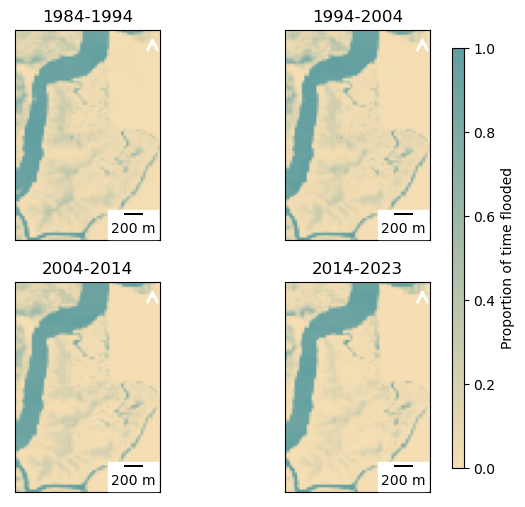

In [19]:
import matplotlib.pyplot as plt
import rasterio
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
import numpy as np


dec84 = 'F:/Flats imagery/84_elev_94.flats.tif'
dec94 = 'F:/Flats imagery/94_elev_04.flats.tif'
dec04 = 'F:/Flats imagery/04_elev_14.flats.tif'
dec14 = 'F:/Flats imagery/14_elev_23.flats.tif'

# dec84 = 'F:/Flats imagery/1984percent1994.flats.tif'
# dec94 = 'F:/Flats imagery/1994percent2004.flats.tif'
# dec04 = 'F:/Flats imagery/2004percent2014.flats.tif'
# dec14 = 'F:/Flats imagery/2014percent2023.flats.tif'

# dec84 = 'F:/Flats imagery/highthreshold1984percent1994.flats.tif'
# dec94 = 'F:/Flats imagery/highthreshold1994percent2004.flats.tif'
# dec04 = 'F:/Flats imagery/highthreshold2004percent2014.flats.tif'
# dec14 = 'F:/Flats imagery/highthreshold2014percent2023.flats.tif'

dec_paths = [dec84, dec94, dec04, dec14]

#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        # Adjust the contrast by using a gamma correction
        gamma = 1  # Experiment with different gamma values
        data = data ** gamma
        
        # Normalize the data to the range [0, 1]
        data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
        
        # Create a custom colormap that maps values from 0 to 1 to colors
        cmap = colors.LinearSegmentedColormap.from_list('custom_cmap',  [(0, '#F5DEB3'), (1, '#5F9EA0')])
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=0, vmax=1)

        # Remove coordinate labels to make the plots larger
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a scale bar
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))

        # Set subplot title
        ax.set_title(title)
        
        return im  # Return the im object

# Create a figure and subplots with adjusted size
fig, axs = plt.subplots(2, 2, figsize=(6, 6))  # Increased figsize

# Initialize im objects
ims = []

# Define titles for each subplot
titles = ['1984-1994', '1994-2004', '2004-2014', '2014-2023']

# Plot each GeoTIFF image with its corresponding title
for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(dec_paths[i], ax, titles[i])
    ims.append(im)

# Add a title for the entire figure (optional)
# plt.suptitle('Flooding frequency by decade', fontsize=16)

# Create a colorbar for the last im object
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ims[-1], cax=cbar_ax, label='Proportion of time flooded', cmap=cmap)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('fig.png',bbox_inches='tight', dpi=300)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('variablethresholddecadespercent.png',bbox_inches='tight', dpi = 300)

# Adjust layout and display the plot
plt.show()

In [20]:
#Filtering by month

ultra_col = l8_col.merge(l5_col).merge(l7_col).merge(l9_col)

# ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')) \
#     .filter(ee.Filter.calendarRange(12, 12, 'month')) \
#     .filterBounds(flux_ga)

ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))  \
    .filter(ee.Filter.calendarRange(12, 12, 'month')) 

#Percentage of pixels in study area flagged, ALL =----= MIGHT BE A BETTER WAY TO DO THIS

study_area = flux_ga.geometry()

# Define the threshold value
threshold = 0.2

# Function to calculate binary image for 'flats' values greater than the threshold
def calculate_binary_image(image):
    flats_band = image.select('flats')
    binary_image = flats_band.gt(threshold)
    return binary_image

# Map the function over the collection to get binary images
binary_images = ultra.map(calculate_binary_image)

# Function to count valid pixels
def count_valid_pixels(image):
    valid_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=study_area,
        scale=30  # Assuming 30-meter resolution
    ).get('flats')
    return image.set('valid_pixel_count', valid_pixel_count)

# Map the function over the binary images to count valid pixels
binary_images_with_count = binary_images.map(count_valid_pixels)

# Filter the collection to exclude scenes with fewer than 100 valid pixels
filtered_images = binary_images_with_count.filter(ee.Filter.gte('valid_pixel_count', 0))

# Reduce the filtered collection to a single image with pixel count
total_count_image = filtered_images.sum()

# Calculate the percentage of times each pixel exceeded the threshold
total_images = filtered_images.size()
percentage_image = total_count_image.divide(total_images).multiply(100)

Map = geemap.Map()
Map.centerObject(flux_ga, 8)
Map.addLayer(percentage_image, {
    'min': 0,
    'max': 100,
    'palette': ['red', 'yellow', 'green']
}, 'Percentage of Times > 0.2')
# Map

image = percentage_image
filename = os.path.join(out_dir, 'dec.tif')

image = image.clip(bb).unmask()

# geemap.ee_export_image(
#     image.select('flats'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )

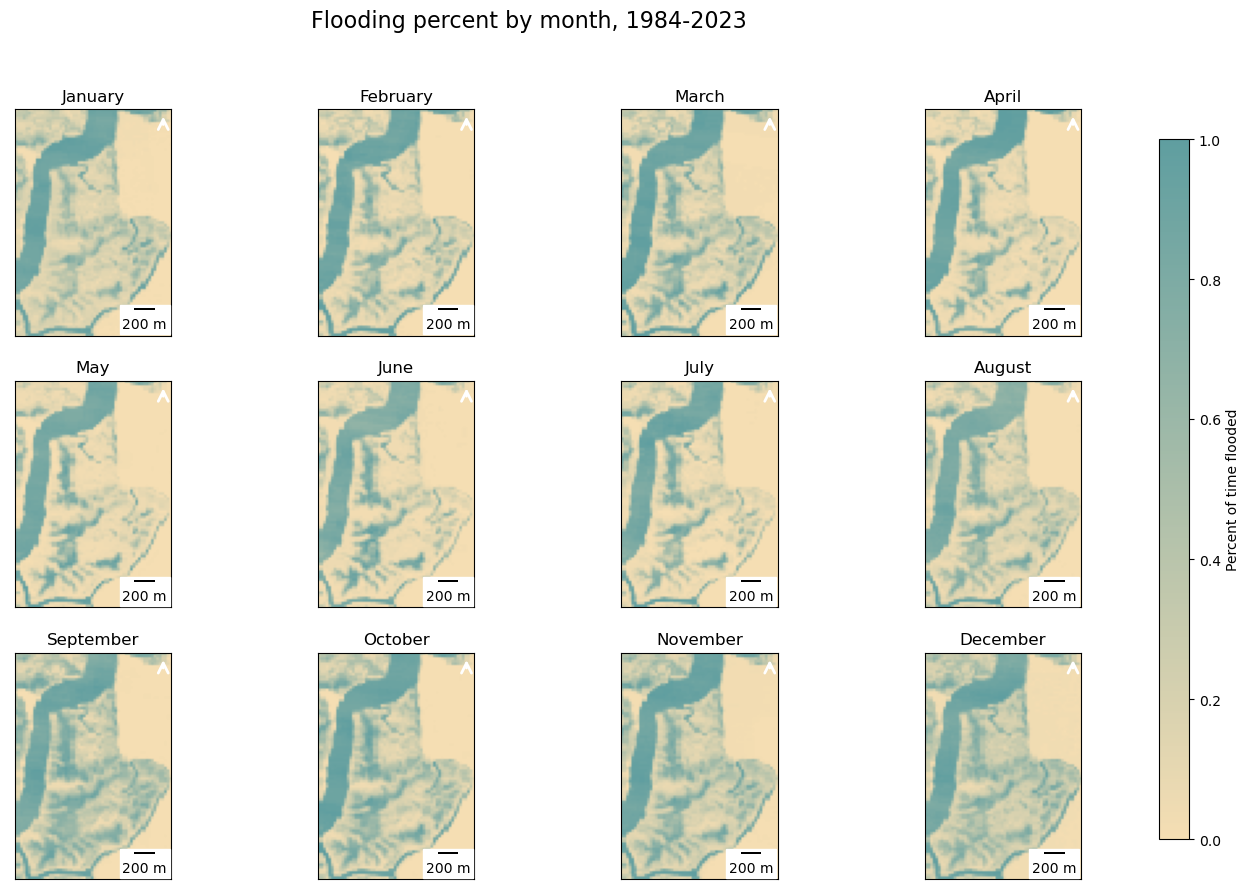

In [21]:
jan = 'F:/Flats imagery/jan.flats.tif'
feb = 'F:/Flats imagery/feb.flats.tif'
mar = 'F:/Flats imagery/mar.flats.tif'
apr = 'F:/Flats imagery/apr.flats.tif'
may = 'F:/Flats imagery/may.flats.tif'
jun = 'F:/Flats imagery/jun.flats.tif'
jul = 'F:/Flats imagery/jul.flats.tif'
aug = 'F:/Flats imagery/aug.flats.tif'
sep = 'F:/Flats imagery/sep.flats.tif'
m_oct = 'F:/Flats imagery/oct.flats.tif'
nov = 'F:/Flats imagery/nov.flats.tif'
dec = 'F:/Flats imagery/dec.flats.tif'

month_paths = [jan,feb,mar,apr,may,jun,jul,aug,sep,m_oct,nov,dec]

#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        # Adjust the contrast by using a gamma correction
        gamma = 1  # Experiment with different gamma values
        data = data ** gamma
        
        # Normalize the data to the range [0, 1]
        data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
        
        # Create a custom colormap that maps values from 0 to 1 to colors
        cmap = colors.LinearSegmentedColormap.from_list('custom_cmap',  [(0, '#F5DEB3'), (1, '#5F9EA0')])
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=0, vmax=1)

        # Remove coordinate labels to make the plots larger
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a scale bar
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))

        # Set subplot title
        ax.set_title(title)
        
        return im  # Return the im object

# Create a figure and subplots with adjusted size
fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # Increased figsize

# Initialize im objects
ims = []

# Define titles for each subplot
titles = ['January', 'February', 'March', 'April','May','June','July','August','September','October','November','December']

# Plot each GeoTIFF image with its corresponding title
for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(month_paths[i], ax, titles[i])
    ims.append(im)

# Add a title for the entire figure (optional)
plt.suptitle('Flooding percent by month, 1984-2023', fontsize=16)

# Create a colorbar for the last im object
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ims[-1], cax=cbar_ax, label='Percent of time flooded', cmap=cmap)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('fig.png',bbox_inches='tight', dpi=300)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('monthspercent.png',bbox_inches='tight', dpi = 300)

# Adjust layout and display the plot
plt.show()

In [22]:
#Adding tide
import glob
import pandas as pd

# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

path = r'C:/Users/arj26323/Documents/Data/flats/Tide data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df

df2 = df.copy()
df2['Time (GMT)'] = pd.to_datetime(df2['Time (GMT)'])
df2['DOY'] = pd.to_datetime(df2['Date'])


time_mask = (df2['Time (GMT)'].dt.hour == 16)
df_time = df2[time_mask]

df_time


# print(df_time.dtypes)

,Date,Time (GMT),Predicted (m),Preliminary (m),Verified (m),DOY
16,1985/01/02,2024-12-19 16:00:00,0.340,-,0.479,1985-01-02
40,1985/01/03,2024-12-19 16:00:00,0.275,-,0.406,1985-01-03
64,1985/01/04,2024-12-19 16:00:00,0.374,-,0.458,1985-01-04
88,1985/01/05,2024-12-19 16:00:00,0.620,-,0.543,1985-01-05
112,1985/01/06,2024-12-19 16:00:00,0.967,-,1.162,1985-01-06
...,...,...,...,...,...,...
350536,1984/12/28,2024-12-19 16:00:00,1.759,-,1.83,1984-12-28
350560,1984/12/29,2024-12-19 16:00:00,1.466,-,1.449,1984-12-29
350584,1984/12/30,2024-12-19 16:00:00,1.148,-,1.104,1984-12-30
350608,1984/12/31,2024-12-19 16:00:00,0.835,-,0.927,1984-12-31


In [23]:
# df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')
# x = df_u['Verified (m)']
# x.quantile(0.67)

#LOW: < 0.8
#Mid: 0.8-1.8
#High: > 1.8

In [24]:
# Get the image IDs and acquisition dates separately
image_ids = ultra_col.aggregate_array('system:id').getInfo()
acquisition_dates = ultra_col.aggregate_array('system:time_start').getInfo()

# Create the DataFrame
dfx = pd.DataFrame({'Image': image_ids, 'acquisition_date': acquisition_dates})

dfx['Date'] = pd.to_datetime(dfx['acquisition_date'], unit='ms')
dfx['DOY'] = dfx['Date'].dt.strftime('%Y-%m-%d')
dfx['DOY'] = pd.to_datetime(dfx['DOY'])

df_u = pd.merge(dfx, df_time, on = 'DOY')

df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')

# Display the DataFrame
# print(dfx)
# print(df_u)

df_u['Verified (m)'] = df_u['Verified (m)'].replace('-', float('nan')).astype('float')

df_low = df_u[df_u['Verified (m)'] <= 0.8]
df_mid = df_u[df_u['Verified (m)'].between(0.8, 1.8)]
df_high = df_u[df_u['Verified (m)'] >= 1.8]

# print(df_high)

In [25]:
# # Create a list of image names
# low_names = df_low['Image'].tolist()
# mid_names = df_mid['Image'].tolist()
# high_names = df_high['Image'].tolist()

# # Initialize separate lists
# LT05_list = []
# LE07_list = []
# LC09_list = []
# LC08_list = []
# other_list = []

# # Iterate through the satellite names and separate them based on keys
# names = low_names

# for name in names:
#     if 'LT05' in name:
#         LT05_list.append(name)
#     elif 'LE07' in name:
#         LE07_list.append(name)
#     elif 'LC09' in name:
#         LC09_list.append(name)
#     elif 'LC08' in name:
#         LC08_list.append(name)
#     else:
#         other_list.append(name)

# col5 = ee.ImageCollection(LT05_list).map(maskL5sr).map(addFLATSL5)
# col7 = ee.ImageCollection(LE07_list).map(maskL5sr).map(addFLATSL7)
# col8 = ee.ImageCollection(LC08_list).map(maskL5sr).map(addFLATSL8)
# col9 = ee.ImageCollection(LC09_list).map(maskL5sr).map(addFLATSL9)

# col = col5.merge(col7).merge(col8).merge(col9)

# # col = col.filter(ee.Filter.calendarRange(1984, 1994,'year')).filterBounds(flux_ga)

# col = col.filter(ee.Filter.calendarRange(2014, 2023,'year')).map(lambda image: image.clip(bb)) \
#     .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

# #Percentage of pixels in study area flagged, ALL =----= MIGHT BE A BETTER WAY TO DO THIS
# study_area = flux_ga.geometry()

# # Define the threshold value
# threshold = 0.2

# # Function to calculate binary image for 'flats' values greater than the threshold
# def calculate_binary_image(image):
#     flats_band = image.select('flats')
#     binary_image = flats_band.gt(threshold)
#     return binary_image

# # Map the function over the collection to get binary images
# binary_images = col.map(calculate_binary_image)

# # Function to count valid pixels
# def count_valid_pixels(image):
#     valid_pixel_count = image.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=study_area,
#         scale=30  # Assuming 30-meter resolution
#     ).get('flats')
#     return image.set('valid_pixel_count', valid_pixel_count)

# # Map the function over the binary images to count valid pixels
# binary_images_with_count = binary_images.map(count_valid_pixels)

# # Filter the collection to exclude scenes with fewer than 100 valid pixels
# filtered_images = binary_images_with_count.filter(ee.Filter.gte('valid_pixel_count', 0))

# # Reduce the filtered collection to a single image with pixel count
# total_count_image = filtered_images.sum()

# # Calculate the percentage of times each pixel exceeded the threshold
# total_images = filtered_images.size()
# percentage_image = total_count_image.divide(total_images).multiply(100)


# #Directory
# out_dir = os.path.join("F:/Flats imagery/Tide stage composites")
# ##Draw geometry for exported images! It will look better

# bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

# image = percentage_image
# filename = os.path.join(out_dir, 'low14.tif')

# image = image.clip(bb).unmask()

# # geemap.ee_export_image(
# #     image.select('flats'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# # )

In [26]:
# Create a list of image names
low_names = df_low['Image'].tolist()
mid_names = df_mid['Image'].tolist()
high_names = df_high['Image'].tolist()

# Initialize separate lists
LT05_list = []
LE07_list = []
LC09_list = []
LC08_list = []
other_list = []

# Iterate through the satellite names and separate them based on keys
names = high_names

for name in names:
    if 'LT05' in name:
        LT05_list.append(name)
    elif 'LE07' in name:
        LE07_list.append(name)
    elif 'LC09' in name:
        LC09_list.append(name)
    elif 'LC08' in name:
        LC08_list.append(name)
    else:
        other_list.append(name)

col5 = ee.ImageCollection(LT05_list).map(maskL5sr).map(addFLATSL5).map(add_elevation)
col7 = ee.ImageCollection(LE07_list).map(maskL5sr).map(addFLATSL7).map(add_elevation)
col8 = ee.ImageCollection(LC08_list).map(maskL5sr).map(addFLATSL8).map(add_elevation)
col9 = ee.ImageCollection(LC09_list).map(maskL5sr).map(addFLATSL9).map(add_elevation)

col = col5.merge(col7).merge(col8).merge(col9)

# col = col.filter(ee.Filter.calendarRange(1984, 1994,'year')).filterBounds(flux_ga)

col = col.filter(ee.Filter.calendarRange(2014, 2023,'year')).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

#Percentage of pixels in study area flagged, ALL =----= MIGHT BE A BETTER WAY TO DO THIS
study_area = flux_ga.geometry()

# Define the threshold value
threshold = 0.2

# Function to calculate the binary image for 'flats' values based on elevation
def calculate_binary_image(image):
    flats_band = image.select('flats')
    elevation_band = image.select('elevation')
    
    # Define the different thresholds based on elevation
    threshold_below_elevation = 0.2
    threshold_above_elevation = 0.8

    binary_image  = flats_band.expression(
        "(elev >= 0.5) ? flats > threshold_above : flats > threshold_below",
        {
            'elev': image.select('elevation'), 
            'flats': flats_band,
            'threshold_above': threshold_above_elevation,
            'threshold_below': threshold_below_elevation
        }
    )

    return binary_image


# Map the function over the collection to get binary images
binary_images = col.map(calculate_binary_image)

# Function to count valid pixels
def count_valid_pixels(image):
    valid_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=study_area,
        scale=30  # Assuming 30-meter resolution
    ).get('flats')
    return image.set('valid_pixel_count', valid_pixel_count)

# Map the function over the binary images to count valid pixels
binary_images_with_count = binary_images.map(count_valid_pixels)

# Filter the collection to exclude scenes with fewer than 100 valid pixels
filtered_images = binary_images_with_count.filter(ee.Filter.gte('valid_pixel_count', 0))

# Reduce the filtered collection to a single image with pixel count
total_count_image = filtered_images.sum()

# Calculate the percentage of times each pixel exceeded the threshold
total_images = filtered_images.size()
percentage_image = total_count_image.divide(total_images).multiply(100)


#Directory
out_dir = os.path.join("F:/Flats imagery/Tide stage composites")
##Draw geometry for exported images! It will look better

bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

image = percentage_image
filename = os.path.join(out_dir, 'elev_high14.tif')

image = image.clip(bb).unmask()

# geemap.ee_export_image(
#     image.select('flats'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )

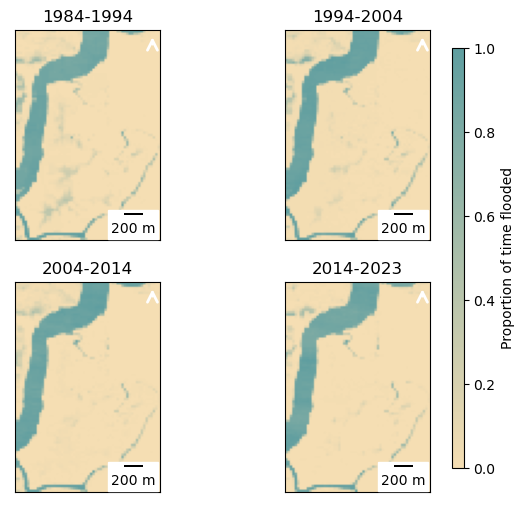

In [27]:
#Plotting decades and tide

low84 = 'F:/Flats imagery/Tide stage composites/elev_low84.flats.tif'
low94 = 'F:/Flats imagery/Tide stage composites/elev_low94.flats.tif'
low04 = 'F:/Flats imagery/Tide stage composites/elev_low04.flats.tif'
low14 = 'F:/Flats imagery/Tide stage composites/elev_low14.flats.tif'

mid84 = 'F:/Flats imagery/Tide stage composites/elev_mid84.flats.tif'
mid94 = 'F:/Flats imagery/Tide stage composites/elev_mid94.flats.tif'
mid04 = 'F:/Flats imagery/Tide stage composites/elev_mid04.flats.tif'
mid14 = 'F:/Flats imagery/Tide stage composites/elev_mid14.flats.tif'

high84 = 'F:/Flats imagery/Tide stage composites/elev_high84.flats.tif'
high94 = 'F:/Flats imagery/Tide stage composites/elev_high94.flats.tif'
high04 = 'F:/Flats imagery/Tide stage composites/elev_high04.flats.tif'
high14 = 'F:/Flats imagery/Tide stage composites/elev_high14.flats.tif'

# low84 = 'F:/Flats imagery/Tide stage composites/low84.flats.tif'
# low94 = 'F:/Flats imagery/Tide stage composites/low94.flats.tif'
# low04 = 'F:/Flats imagery/Tide stage composites/low04.flats.tif'
# low14 = 'F:/Flats imagery/Tide stage composites/low14.flats.tif'

# mid84 = 'F:/Flats imagery/Tide stage composites/mid84.flats.tif'
# mid94 = 'F:/Flats imagery/Tide stage composites/mid94.flats.tif'
# mid04 = 'F:/Flats imagery/Tide stage composites/mid04.flats.tif'
# mid14 = 'F:/Flats imagery/Tide stage composites/mid14.flats.tif'

# high84 = 'F:/Flats imagery/Tide stage composites/high84.flats.tif'
# high94 = 'F:/Flats imagery/Tide stage composites/high94.flats.tif'
# high04 = 'F:/Flats imagery/Tide stage composites/high04.flats.tif'
# high14 = 'F:/Flats imagery/Tide stage composites/high14.flats.tif'

low_paths = [low84, low94, low04, low14]
mid_paths = [mid84, mid94, mid04, mid14]
high_paths = [high84, high94, high04, high14]

x_paths = low_paths #INPUT PATH HERE

#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
    # Open the GeoTIFF file
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        # Adjust the contrast by using a gamma correction
        gamma = 1  # Experiment with different gamma values
        data = data ** gamma
        
        # Normalize the data to the range [0, 1]
        data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
        
        # Create a custom colormap that maps values from 0 to 1 to colors
        cmap = colors.LinearSegmentedColormap.from_list('custom_cmap',  [(0, '#F5DEB3'), (1, '#5F9EA0')])
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=0, vmax=1)

        # Remove coordinate labels to make the plots larger
        ax.set_xticks([])
        ax.set_yticks([])

        # Add a scale bar
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))

        # Set subplot title
        ax.set_title(title)
        
        return im  # Return the im object

# Create a figure and subplots with adjusted size
fig, axs = plt.subplots(2, 2, figsize=(6, 6))  # Increased figsize

# Initialize im objects
ims = []

# Define titles for each subplot
titles = ['1984-1994', '1994-2004', '2004-2014', '2014-2023']

# Plot each GeoTIFF image with its corresponding title
for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(x_paths[i], ax, titles[i]) 
    ims.append(im)

# Add a title for the entire figure (optional)
# plt.suptitle('Flooding frequency by decade - low tide', fontsize=16)

# Create a colorbar for the last im object
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(ims[-1], cax=cbar_ax, label='Proportion of time flooded', cmap=cmap)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('elev_lowtide.png',bbox_inches='tight', dpi=300)


# Adjust layout and display the plot
plt.show()

In [28]:
#Slope of flats, by pixel

# Create a list of image names
low_names = df_low['Image'].tolist()
mid_names = df_mid['Image'].tolist()
high_names = df_high['Image'].tolist()

# Initialize separate lists
LT05_list = []
LE07_list = []
LC09_list = []
LC08_list = []
other_list = []

# Iterate through the satellite names and separate them based on keys
names = high_names

for name in names:
    if 'LT05' in name:
        LT05_list.append(name)
    elif 'LE07' in name:
        LE07_list.append(name)
    elif 'LC09' in name:
        LC09_list.append(name)
    elif 'LC08' in name:
        LC08_list.append(name)
    else:
        other_list.append(name)

col5 = ee.ImageCollection(LT05_list).map(maskL5sr).map(addFLATSL5).map(add_elevation)
col7 = ee.ImageCollection(LE07_list).map(maskL5sr).map(addFLATSL7).map(add_elevation)
col8 = ee.ImageCollection(LC08_list).map(maskL5sr).map(addFLATSL8).map(add_elevation)
col9 = ee.ImageCollection(LC09_list).map(maskL5sr).map(addFLATSL9).map(add_elevation)

col = col5.merge(col7).merge(col8).merge(col9)

# col = col.filter(ee.Filter.calendarRange(1984, 1994,'year')).filterBounds(flux_ga)

study_area = flux_ga.geometry()

col = col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50)).filterBounds(study_area)

# Function to calculate linear regression for each pixel
def add_time(image):
    # Add a band representing time in years
    time = image.metadata('system:time_start').divide(31536000000)  # milliseconds to years
    return image.addBands(time.rename('time'))

colx = col.map(add_time)

# Perform linear regression for each pixel
linearFit = colx.select(['time', 'flats']).reduce(
        reducer=ee.Reducer.linearFit()
    )

In [29]:
low_names

['LANDSAT/LC08/C02/T1_L2/LC08_016038_20130701',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20130802',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20130818',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20130903',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20140210',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20140314',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20140821',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20140906',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20140922',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20150317',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20150402',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20150909',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20150925',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20160216',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20160319',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20160404',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20160420',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20160911',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20160927',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_20161013',
 'LANDSAT/LC08/C02/T1_L2/LC08_016038_201

In [30]:
#Directory
out_dir = os.path.join("F:/Flats imagery/Tide stage composites")
##Draw geometry for exported images! It will look better

bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

image = linearFit
filename = os.path.join(out_dir, 'high_slope.tif')

image = image.clip(bb).unmask()

# geemap.ee_export_image(
#     image.select('scale'), filename=filename, scale=30, region=flux_ga.geometry(), file_per_band=True
# )

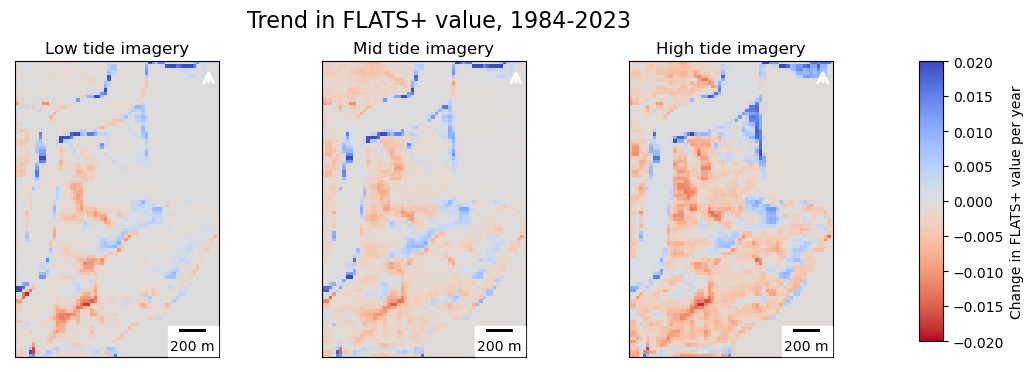

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import geopandas as gpd
from geopy.distance import great_circle
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

h_x = "F:/Flats imagery/Tide stage composites/high_slope.scale.tif"
m_x = "F:/Flats imagery/Tide stage composites/mid_slope.scale.tif"
l_x = "F:/Flats imagery/Tide stage composites/low_slope.scale.tif"

slope_paths = [l_x, m_x, h_x]

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, data_min, data_max):
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        gamma = 1
        data = data ** gamma 

        # Normalize the data based on the overall min and max values
#         data_normalized = (data - data_min) / (data_max - data_min)
        
        cmap = 'coolwarm_r'
        im = ax.imshow(data, extent=extent, cmap=cmap, vmin=-0.02, vmax=0.02)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))
        
        ax.set_title(title)
        
        return im

# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjusted figsize

ims = []
titles = ['Low tide imagery', 'Mid tide imagery', 'High tide imagery']
data_min = float('inf')
data_max = float('-inf')

for i, ax in enumerate(axs.flat):
    with rasterio.open(slope_paths[i]) as src:
        data = src.read(1)
        data_min = min(data_min, np.min(data))
        data_max = max(data_max, np.max(data))

for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(slope_paths[i], ax, titles[i], data_min, data_max)
    ims.append(im)

plt.suptitle('Trend in FLATS+ value, 1984-2023', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = plt.colorbar(ims[-1], cax=cbar_ax, label='Change in FLATS+ value per year')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('slopes_trend.png',bbox_inches='tight', dpi = 300)

plt.show()


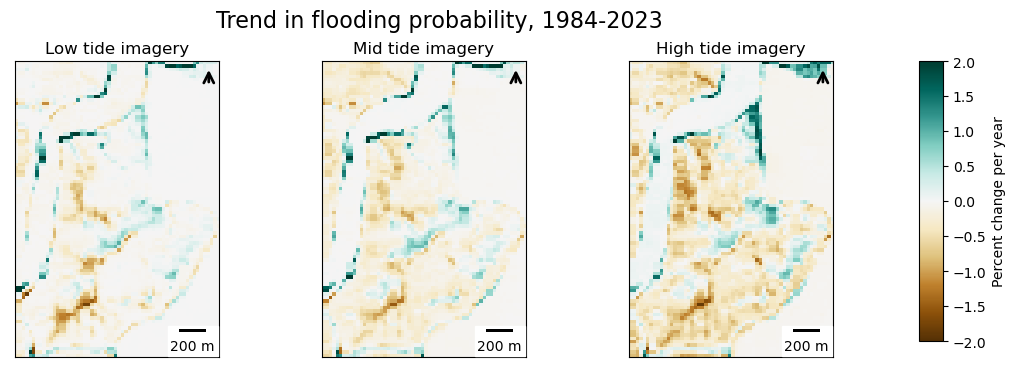

In [32]:
#FLATS COLOR PERCENTAGE PLOTTING

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import geopandas as gpd
from geopy.distance import great_circle
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

h_x = "F:/Flats imagery/Tide stage composites/high_slope.scale.tif"
m_x = "F:/Flats imagery/Tide stage composites/mid_slope.scale.tif"
l_x = "F:/Flats imagery/Tide stage composites/low_slope.scale.tif"

slope_paths = [l_x, m_x, h_x]

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, data_min, data_max):
    with rasterio.open(geotiff_path) as src:
        data = src.read(1)
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        gamma = 1
        data = data ** gamma 

        # Normalize the data based on the overall min and max values
        data_normalized = (data) / (1)*100
        
        cmap = 'BrBG'
        im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=-2, vmax=2)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        
        ax.set_title(title)
        
        return im

# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjusted figsize

ims = []
titles = ['Low tide imagery', 'Mid tide imagery', 'High tide imagery']
data_min = float('inf')
data_max = float('-inf')

for i, ax in enumerate(axs.flat):
    with rasterio.open(slope_paths[i]) as src:
        data = src.read(1)
        data_min = min(data_min, np.min(data))
        data_max = max(data_max, np.max(data))

for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(slope_paths[i], ax, titles[i], data_min, data_max)
    ims.append(im)

plt.suptitle('Trend in flooding probability, 1984-2023', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# cbar.set_ticks([-0.02, -0.01, 0, 0.01, 0.02])
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = plt.colorbar(ims[-1], cax=cbar_ax, label='Percent change per year')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('percentslopes_trend.png',bbox_inches='tight', dpi = 300)

plt.show()


In [33]:
data

array([[-0.00187043, -0.00374147, -0.00374147, ...,  0.01588048,
         0.01606456,  0.00554725],
       [ 0.00043498, -0.00115937, -0.00115937, ...,  0.00904961,
         0.0015437 , -0.00071536],
       [ 0.00024601, -0.0026198 , -0.0026198 , ...,  0.00806061,
        -0.0008499 , -0.00097484],
       ...,
       [-0.00443585, -0.00443585, -0.00636827, ..., -0.00030532,
        -0.00029583, -0.00030571],
       [-0.00703189, -0.00703189, -0.00890807, ..., -0.00030906,
        -0.00030735, -0.00029757],
       [-0.00812796, -0.00812796, -0.00896122, ..., -0.00030779,
        -0.00034035, -0.00029978]])

In [34]:
# #Plotting
# import matplotlib.colors as colors
# from matplotlib_scalebar.scalebar import ScaleBar
# import rasterio
# import geopandas as gpd

# h_x = "F:/Flats imagery/Tide stage composites/high_slope.scale.tif"
# m_x = "F:/Flats imagery/Tide stage composites/mid_slope.scale.tif"
# l_x = "F:/Flats imagery/Tide stage composites/low_slope.scale.tif"

# slope_paths = [l_x, m_x, h_x]

# #Calculating dx for scale_bar
# from geopy.distance import great_circle
# point1 = (31.425,-81.29) 
# point2 = (31.425,-80.29)  
# dx = great_circle(point1, point2).meters

# def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title):
#     # Open the GeoTIFF file
#     with rasterio.open(geotiff_path) as src:
#         data = src.read(1)  # Assuming it's a single-band image
#         extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
#         # Adjust the contrast by using a gamma correction
#         gamma = 1  # Experiment with different gamma values
#         data = data ** gamma
        
#         # Normalize the data to the range [0, 1]
#         data_normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
        
#         # Create a custom colormap that maps values from 0 to 1 to colors
#         cmap = colors.LinearSegmentedColormap.from_list('custom_cmap',  [(0, 'red'), (0.5, 'gray'), (1, 'blue')])
        
#         # Plot the GeoTIFF data using imshow
#         im = ax.imshow(data_normalized, extent=extent, cmap=cmap, vmin=-1, vmax=1)

#         # Remove coordinate labels to make the plots larger
#         ax.set_xticks([])
#         ax.set_yticks([])

#         # Add a scale bar
#         scale_bar = ScaleBar(dx=dx, location='lower right')
#         ax.add_artist(scale_bar)

#         # Enhance the visibility of the north arrow
#         ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
#                     xytext=(0.95, 0.92), textcoords='axes fraction',
#                     arrowprops=dict(arrowstyle='->', lw=2, color='white'))

#         # Set subplot title
#         ax.set_title(title)
        
#         return im  # Return the im object

# # Create a figure and subplots with adjusted size
# fig, axs = plt.subplots(1, 3, figsize=(6, 6))  # Increased figsize

# # Initialize im objects
# ims = []

# # Define titles for each subplot
# titles = ['Low tide', 'Mid tide', 'High tide']

# # Plot each GeoTIFF image with its corresponding title
# for i, ax in enumerate(axs.flat):
#     im = plot_geotiff_with_scale_and_north_arrow(slope_paths[i], ax, titles[i])
#     ims.append(im)

# # Add a title for the entire figure (optional)
# plt.suptitle('Trend in FLATS value, 1984-2023', fontsize=16)

# # Create a colorbar for the last im object
# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(ims[-1], cax=cbar_ax, label='Slope', cmap=\
#              colors.LinearSegmentedColormap.from_list('custom_cmap',  [(-1, 'red'), (0, 'gray'), (1, 'blue')]))

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('variablethresholddecadespercent.png',bbox_inches='tight', dpi = 300)

# Adjust layout and display the plot
plt.show()

# #Calculating dx for scale_bar
# from geopy.distance import great_circle
# point1 = (31.425,-81.29) 
# point2 = (31.425,-80.29)  
# dx = great_circle(point1, point2).meters

# geotidd_path = h_x

# with rasterio.open(geotiff_path) as src:
#         data = src.read(1)  # Assuming it's a single-band image
#         extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)    
        
#         # Use a colormap with better visibility
#         cmap = colors.LinearSegmentedColormap.from_list('custom',  [(0, 'red'), (0.5, 'gray'), (1, 'blue')])
        
#         fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,10))
        
#         # Plot the GeoTIFF data using imshow
#         im = ax.imshow(data, extent=extent, cmap=cmap, vmin=-0.05, vmax=0.05)

#         # Remove coordinate labels to make the plots larger
# #         ax.set_xticks([])
# #         ax.set_yticks([])

#         # Add a scale bar
#         # Calculate the scale factor based on the pixel size (assuming meters)
#         pixel_size_x = 30  # 30 meters in the x-direction
#         scale_factor = pixel_size_x

#         # Add a scale bar using the calculated scale factor
#         scale_bar = ScaleBar(dx=dx, location='lower right')
#         ax.add_artist(scale_bar)
        
#         plt.suptitle('Trend in FLATS, 1984-2023: High tide', fontsize=16)

#         # Enhance the visibility of the north arrow
#         ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
#                     xytext=(0.95, 0.92), textcoords='axes fraction',
#                     arrowprops=dict(arrowstyle='->', lw=2, color='white'))
        
#         fig.subplots_adjust(right=0.95)
#         cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#         fig.colorbar(im, cax=cbar_ax, label = 'Slope', cmap = \
#                           colors.LinearSegmentedColormap.from_list('custom_gray',  [(-0.05, 'black'), (0.05, 'blue')]))
        
        
# print(src.crs)

# # Savefig
# import os
# os.chdir("C:/Users/arj26323/Downloads")
# # plt.savefig('high_slope.png',bbox_inches='tight', dpi = 300)

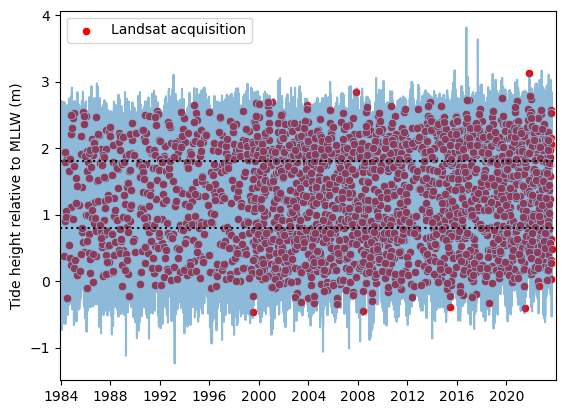

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Landsat occurence and tide - need MLLW plotted against flooding percent too!
df3 = df.copy()
df3['Time'] = pd.to_datetime(df3['Time (GMT)'])
df3['DOY'] = pd.to_datetime(df3['Date'])

df3 #all tides, hourly, from earlier section
df3['datetime'] = pd.to_datetime(df3['Date'] + ' ' + df3['Time (GMT)'])
df3['Verified (m)'] = df3['Verified (m)'].replace('-', float('nan')).astype('float')

dfx['datetime'] = dfx['Date'].dt.round('H')
df0 = pd.merge(dfx, df3, on = 'datetime')

df3 = df3[df3['DOY'] < '2023-10-02']
df0 = df0[df0['DOY_x'] < '2023-10-02']


MHHW = 2.287

# Create a figure and axis object
fig, ax = plt.subplots()

# Long-term plot of tidal cycle
sns.lineplot(
    x="datetime",
    y="Verified (m)",
    legend=False,
    alpha=0.5,
    data=df3,
    ax=ax
)

# ax.axhline(2.287, ls='--', color = 'yellow')
# ax.text(5000,2, "MHHW", color = 'yellow')

# Scatter plot for image acquisition dates from dfx
sns.scatterplot(
    x="datetime",
    y="Verified (m)",  # Use the tidal height values for y
    marker='o',
    color='red',
    data=df0,
    ax=ax,
    label="Landsat acquisition"  # Add a label for the legend

)

start_date = pd.to_datetime('1983-12-01')
end_date = pd.to_datetime('2023-12-31')  # Extend beyond 2024
plt.xlim(start_date, end_date)

plt.ylabel("Tide height relative to MLLW (m)")
plt.xlabel("")
plt.legend()

#add horizontal quantile lines
plt.axhline(y=0.8, color='black', linestyle=':')
plt.axhline(y=1.8, color='black', linestyle=':')


# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('landtide.png',bbox_inches='tight', dpi = 300)

plt.show()

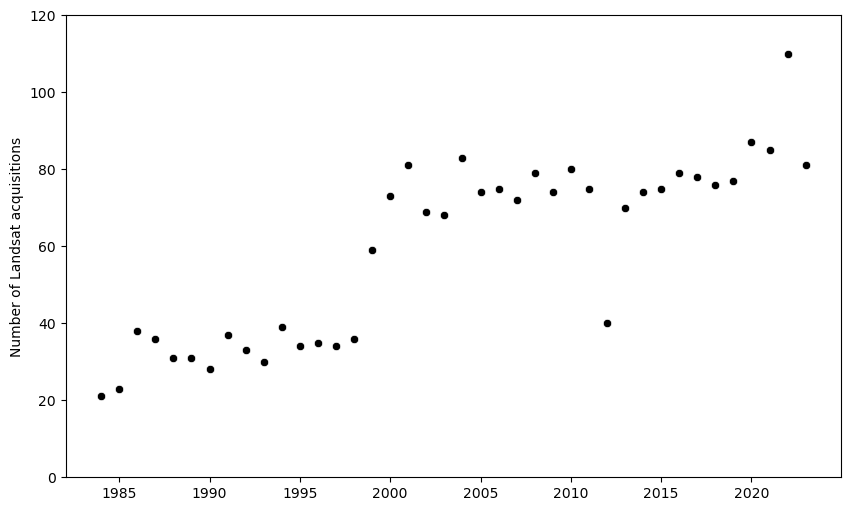

In [36]:
#Per year, number of landsat scenes
df0

# Extract year from 'datetime' column
df0['Year'] = df0['datetime'].dt.year

# Count the number of images per year
image_count_per_year = df0.groupby('Year').size().reset_index(name='Image Count')

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
g = sns.scatterplot(data=image_count_per_year, x='Year', y='Image Count', marker='o', color = 'black')

# g.set_axis_labels("", "Number of Landsat acquisitions")
plt.xlabel("")
plt.ylabel("Number of Landsat acquisitions")

g.set(ylim=(0, 120))  # Set the y-axis limits

import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('ls_aqs', bbox_inches='tight', dpi = 300)

plt.show()

In [37]:
image_count_per_year

# image_count_per_year.to_csv(r'C:\Users\arj26323\Downloads\imcount.csv', index=False, header=True)


,Year,Image Count
0,1984,21
1,1985,23
2,1986,38
3,1987,36
4,1988,31
5,1989,31
6,1990,28
7,1991,37
8,1992,33
9,1993,30
